In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "ecommerce_customer_segmentation.csv"  # Default path in Google Colab
df = pd.read_csv(file_path)

# Display the first 5 rows of the dataset
print("Dataset Overview:")
print(df.head())

# Check the structure and basic information
print("\nDataset Information:")
print(df.info())

# Summary statistics for numeric columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Overview:
   InvoiceNo  CustomerID InvoiceDate  Amount  Country
0       1001       12345  2024-01-01     250      USA
1       1002       12346  2024-01-02     150       UK
2       1003       12347  2024-01-03     300      USA
3       1004       12345  2024-01-04     400      USA
4       1005       12348  2024-01-05     100  Germany

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InvoiceNo    5 non-null      int64 
 1   CustomerID   5 non-null      int64 
 2   InvoiceDate  5 non-null      object
 3   Amount       5 non-null      int64 
 4   Country      5 non-null      object
dtypes: int64(3), object(2)
memory usage: 328.0+ bytes
None

Summary Statistics:
         InvoiceNo   CustomerID      Amount
count     5.000000      5.00000    5.000000
mean   1003.000000  12346.20000  240.000000
std       1.581139      1.30384  119

Top 5 Customers by Toyal Spending:
   CustomerID  Total_Spending
0       12345             650
2       12347             300
1       12346             150
3       12348             100


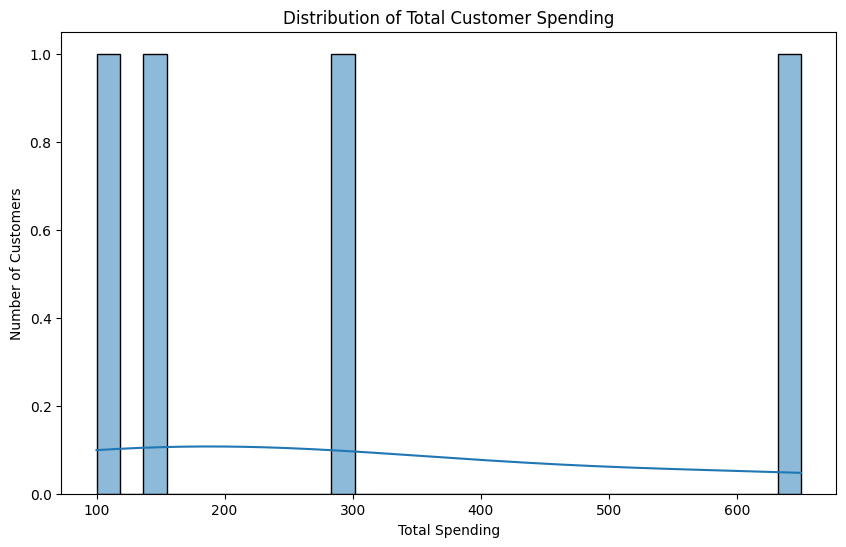

In [4]:
# group by customerID to calculate the total amount spent
customer_spending = df.groupby('CustomerID')['Amount'].sum().reset_index()

# rename colomuns for clarity
customer_spending.columns = ["CustomerID", "Total_Spending"]


#Display top customers by spending

print("Top 5 Customers by Toyal Spending:")
print(customer_spending.sort_values(by="Total_Spending", ascending=False).head())

# Plot a histogram to see the spending distribution
plt.figure(figsize=(10, 6))
sns.histplot(customer_spending["Total_Spending"], bins=30, kde=True)  # Fixed "True" here
plt.title("Distribution of Total Customer Spending")
plt.xlabel("Total Spending")
plt.ylabel("Number of Customers")
plt.show()

Top 5 Customers by Transaction Count:
   CustomerID  Transaction_Count
0       12345                  2
1       12346                  1
2       12347                  1
3       12348                  1


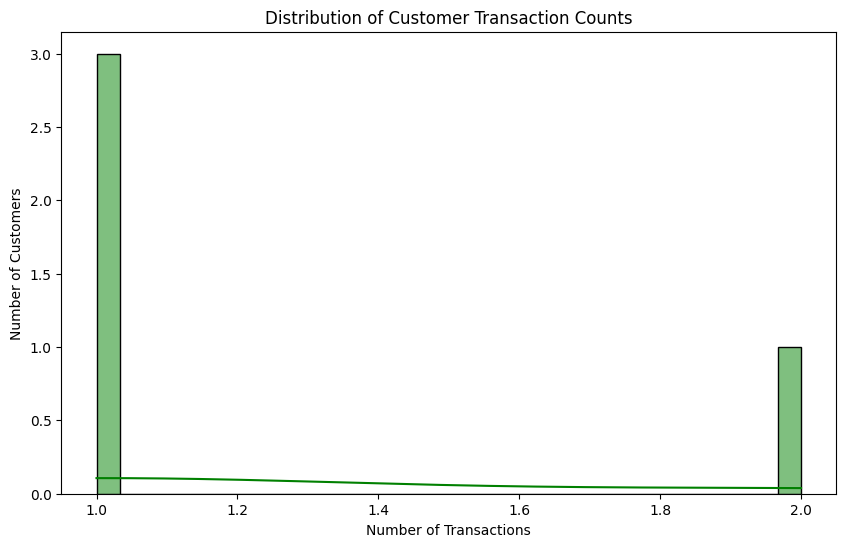

In [5]:
# Group by CustomerID to count the number of invoices (transactions)
customer_frequency = df.groupby("CustomerID")["InvoiceNo"].count().reset_index()

# Rename columns for clarity
customer_frequency.columns = ["CustomerID", "Transaction_Count"]

# Display top customers by transaction count
print("Top 5 Customers by Transaction Count:")
print(customer_frequency.sort_values(by="Transaction_Count", ascending=False).head())

# Plot the distribution of transaction counts
plt.figure(figsize=(10, 6))
sns.histplot(customer_frequency["Transaction_Count"], bins=30, kde=True, color="green")
plt.title("Distribution of Customer Transaction Counts")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Customers")
plt.show()

Top 5 Customers with the Least Recency:
   CustomerID InvoiceDate  Recency
3       12348  2024-01-05        0
0       12345  2024-01-04        1
2       12347  2024-01-03        2
1       12346  2024-01-02        3


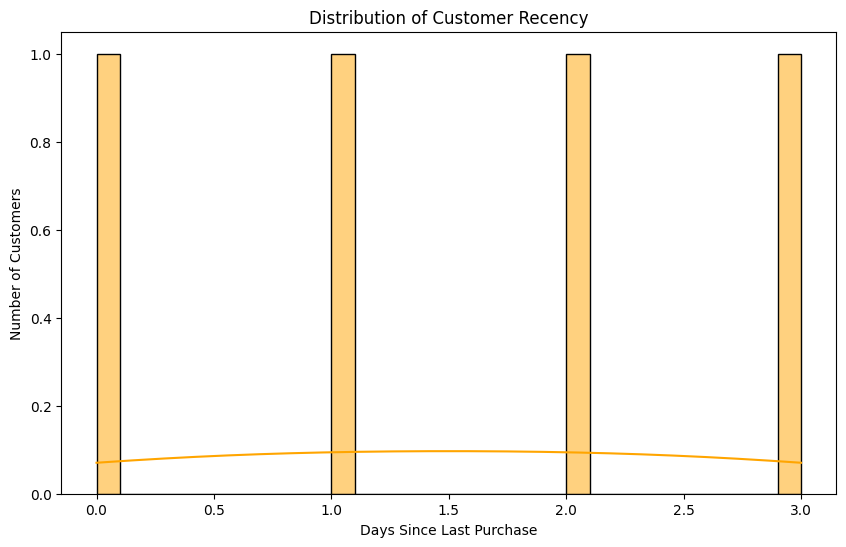

In [6]:
# Convert InvoiceDate to a datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Find the most recent date in the dataset
max_date = df["InvoiceDate"].max()

# Group by CustomerID and find the last purchase date
customer_recency = df.groupby("CustomerID")["InvoiceDate"].max().reset_index()

# Calculate recency (days since last purchase)
customer_recency["Recency"] = (max_date - customer_recency["InvoiceDate"]).dt.days

# Display top customers with the least recency (most recent buyers)
print("Top 5 Customers with the Least Recency:")
print(customer_recency.sort_values(by="Recency").head())

# Plot the distribution of recency
plt.figure(figsize=(10, 6))
sns.histplot(customer_recency["Recency"], bins=30, kde=True, color="orange")
plt.title("Distribution of Customer Recency")
plt.xlabel("Days Since Last Purchase")
plt.ylabel("Number of Customers")
plt.show()

In [7]:
# Combine RFM metrics into one DataFrame

# Merge Recency
rfm = customer_recency[["CustomerID", "Recency"]]

# Merge Frequency
rfm = rfm.merge(customer_frequency[["CustomerID", "Transaction_Count"]], on="CustomerID", how="left")

# Merge Monetary Value
rfm = rfm.merge(customer_spending[["CustomerID", "Total_Spending"]], on="CustomerID", how="left")

# Rename columns for clarity
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

# Display the RFM table
print("RFM Table:")
print(rfm.head())

RFM Table:
   CustomerID  Recency  Frequency  Monetary
0       12345        1          2       650
1       12346        3          1       150
2       12347        2          1       300
3       12348        0          1       100


In [8]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Copy the RFM data for clustering
rfm_data = rfm[["Recency", "Frequency", "Monetary"]]

# Step 1: Normalize the data using StandardScaler
scaler = StandardScaler()  # Initialize the scaler
rfm_scaled = scaler.fit_transform(rfm_data)

# Step 2: Apply K-Means Clustering
# Choose the number of clusters (K) as 3 for simplicity
kmeans = KMeans(n_clusters=3, random_state=42)  # Initialize the K-Means model
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)  # Add cluster labels to RFM table

# Display the first 5 rows of the RFM table with cluster labels
print("RFM Table with Cluster Labels:")
print(rfm.head())


RFM Table with Cluster Labels:
   CustomerID  Recency  Frequency  Monetary  Cluster
0       12345        1          2       650        1
1       12346        3          1       150        0
2       12347        2          1       300        0
3       12348        0          1       100        2


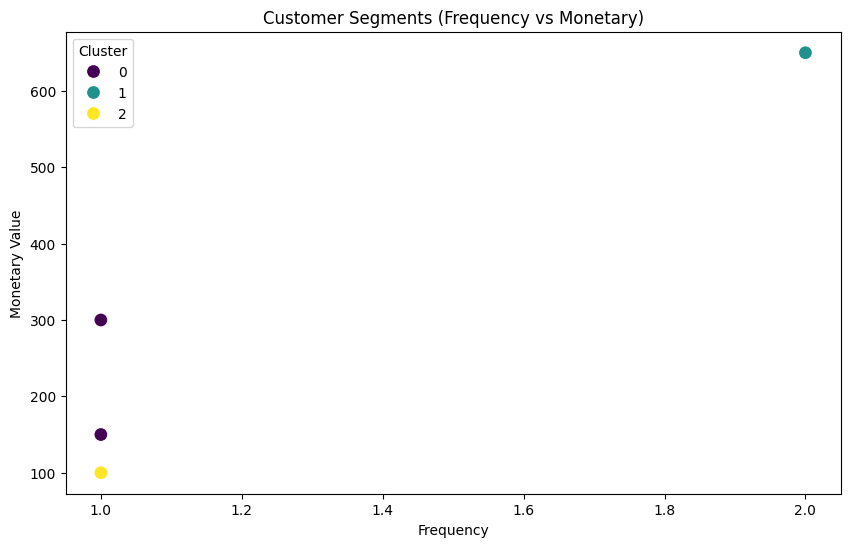

In [9]:
# Visualize the clusters
plt.figure(figsize=(10, 6))

# Scatter plot: Frequency vs Monetary with clusters
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="viridis", s=100)
plt.title("Customer Segments (Frequency vs Monetary)")
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.legend(title="Cluster")
plt.show()

In [10]:
# Calculate the mean values of Recency, Frequency, and Monetary for each cluster
cluster_analysis = rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().reset_index()

# Display cluster analysis
print("Cluster Analysis:")
print(cluster_analysis)

Cluster Analysis:
   Cluster  Recency  Frequency  Monetary
0        0      2.5        1.0     225.0
1        1      1.0        2.0     650.0
2        2      0.0        1.0     100.0


In [11]:
# Save the RFM table with clusters to a CSV file
rfm.to_csv("customer_segments_with_clusters.csv", index=False)
print("File saved successfully!")

File saved successfully!
